In [63]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D

In [64]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_sizes = [256, 256]

lr = 0.001

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(3 * 32 * 32, hidden_layer_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_layer_sizes[0])
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes) - 1)])
        self.fc_out = nn.Linear(hidden_layer_sizes[-1], 10)
        
#         for i, l in enumerate(self.linears):
#             self.linears[i].weight.data.copy_(torch.eye(self.linears[i].weight.size(0)))

    def forward(self, x):
        activations = []
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc_in(x))
        activations = np.expand_dims(x.cpu().data.numpy(), axis=1)
        # x = self.bn1(x)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            activations = np.append(activations, np.expand_dims(x.cpu().data.numpy(), axis=1), axis=1)
            # x = self.bns[i](x)
        x = self.fc_out(x)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc_in): Linear (3072 -> 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (linears): ModuleList (
    (0): Linear (256 -> 256)
  )
  (bns): ModuleList (
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc_out): Linear (256 -> 10)
)


In [66]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        for layer in range(self.train_activations.shape[1]):
            dims = np.random.choice(hidden_layer_sizes[layer], 3)
            elems = self.train_activations[:,layer,dims]
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(elems[:,0], elems[:,1], elems[:,2])
            ax.set_xlabel(dims[0])
            ax.set_ylabel(dims[1])
            ax.set_zlabel(dims[2])
            ax.set_xlim(0, 2)
            ax.set_ylim(0, 2)
            ax.set_zlim(0, 2)
            plt.title('Layer : %d dims : (%d, %d, %d)' % (layer, dims[0], dims[1], dims[2]))
            plt.show()
        print(self.train_activations.shape)
        

In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [68]:
if cuda:
    model.cuda()
    criterion.cuda()

In [71]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 500:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

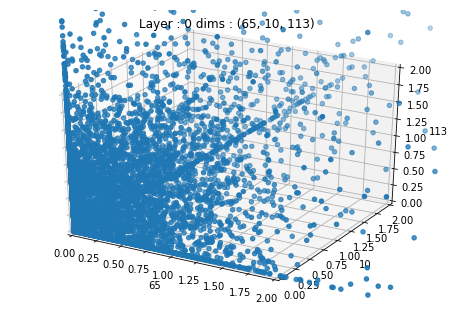

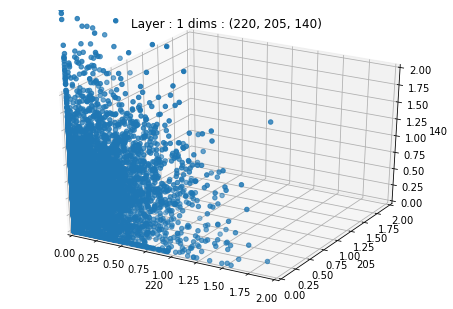

(8032, 2, 256)
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.937099
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.487874
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.260463
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.144411
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.774166
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.866142
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.138704
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.672433

Test set: Average loss: 1.3588, Accuracy: 5194/10000 (52%)



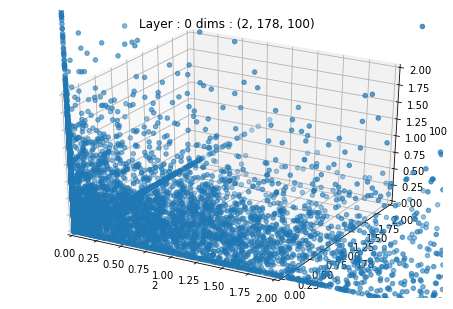

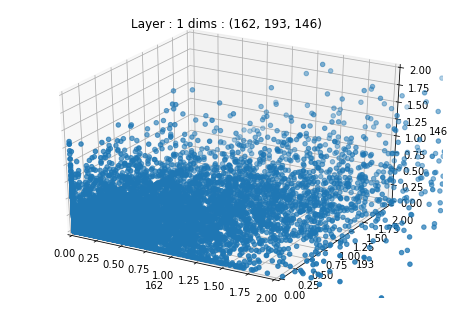

(8032, 2, 256)
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.588212
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.268769
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.224441
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.136806
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.175072
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.997981
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.057879
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.082350

Test set: Average loss: 1.3341, Accuracy: 5318/10000 (53%)



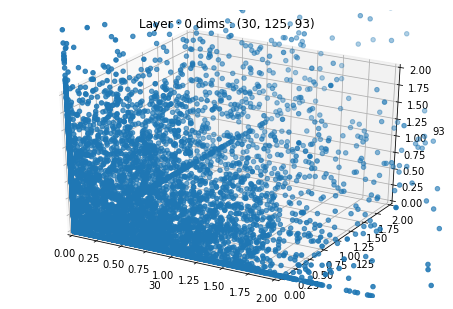

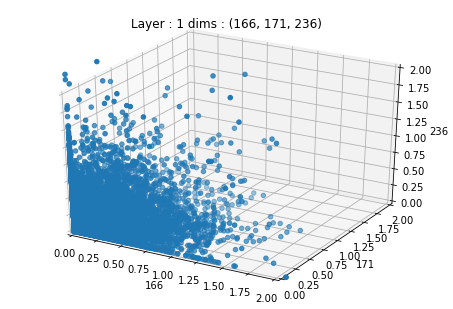

(8032, 2, 256)
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.971342
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.566373
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.383856
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.962572
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.183036
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.320953
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.286003
Train Epoch: 3 [44800/50000 (90%)]	Loss: 0.911431

Test set: Average loss: 1.3408, Accuracy: 5263/10000 (53%)



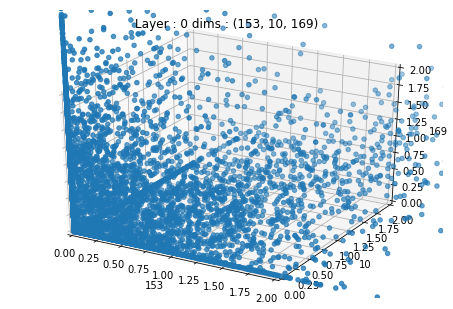

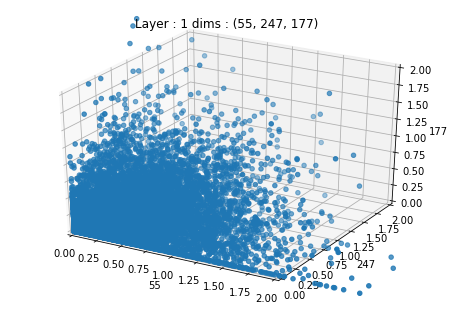

(8032, 2, 256)
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.032884
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.219811
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.452106
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.159757
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.121444
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.176651
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.185770
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.169525

Test set: Average loss: 1.3427, Accuracy: 5285/10000 (53%)



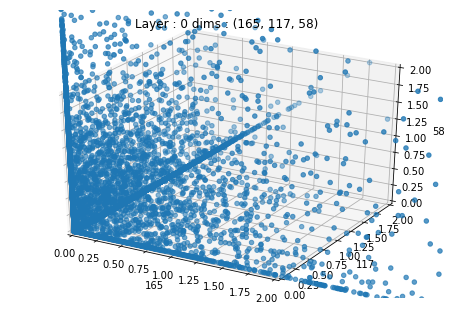

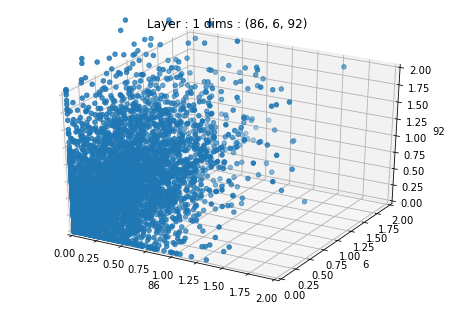

(8032, 2, 256)
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.039723
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.150371
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.228128
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.338870
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.910622
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.042705
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.878694
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.815745

Test set: Average loss: 1.3515, Accuracy: 5286/10000 (53%)



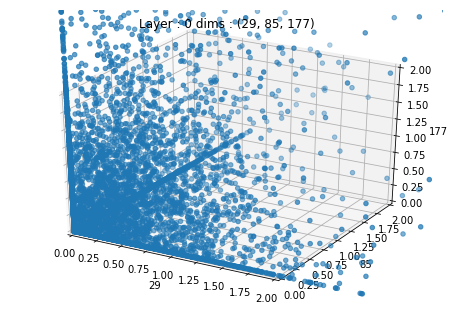

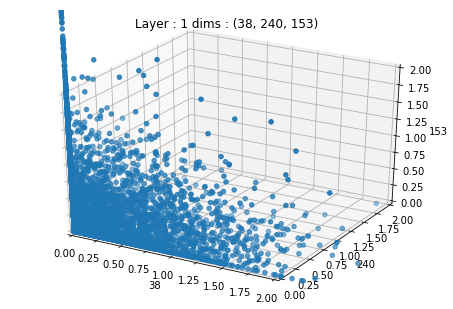

(8032, 2, 256)
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.090248
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.469340
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.507558
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.291367
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.775710
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.693906
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.283054
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.419053

Test set: Average loss: 1.3326, Accuracy: 5432/10000 (54%)



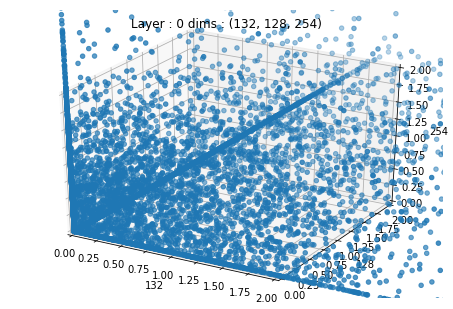

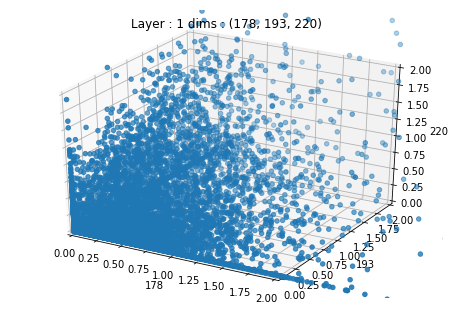

(8032, 2, 256)
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.692047
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.145403
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.125226
Train Epoch: 7 [19200/50000 (38%)]	Loss: 0.948446
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.901421
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.402553
Train Epoch: 7 [38400/50000 (77%)]	Loss: 0.941608
Train Epoch: 7 [44800/50000 (90%)]	Loss: 0.791969

Test set: Average loss: 1.3233, Accuracy: 5417/10000 (54%)



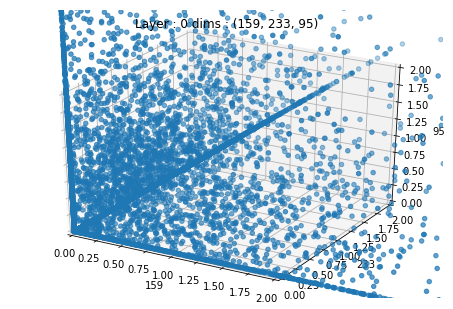

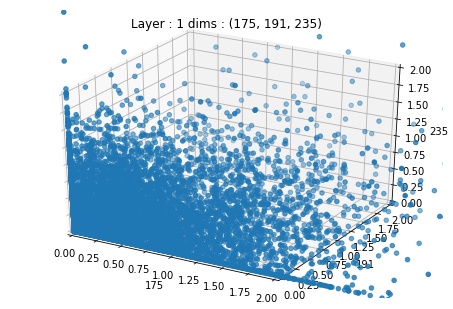

(8032, 2, 256)
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.698619
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.985584
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.802612
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.944620
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.895399
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.744923
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.816060
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.648650

Test set: Average loss: 1.3390, Accuracy: 5428/10000 (54%)



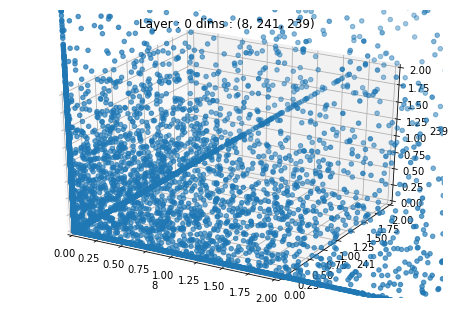

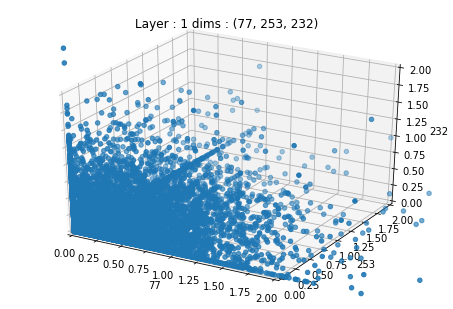

(8032, 2, 256)
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.747345
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.367692
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.805412
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.048877
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.045456
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.870490
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.853211
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.872199

Test set: Average loss: 1.3470, Accuracy: 5442/10000 (54%)



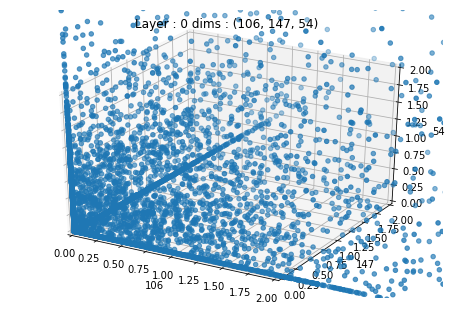

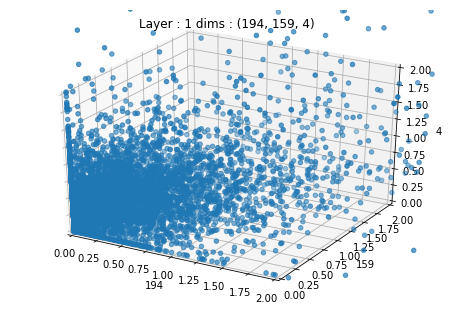

(8032, 2, 256)
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.498917
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.935090
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.306194
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.897205
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.197845
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.494316
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.091344
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.775718

Test set: Average loss: 1.3644, Accuracy: 5461/10000 (55%)



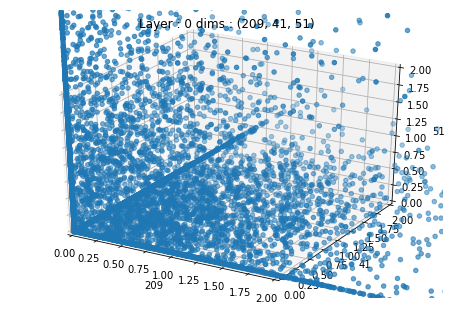

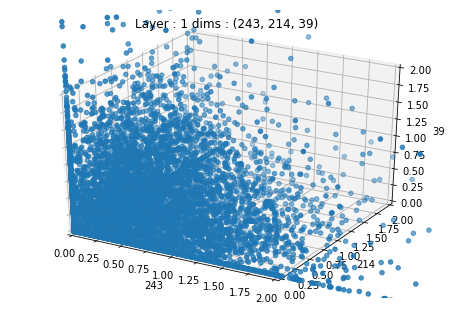

(8032, 2, 256)
Train Epoch: 11 [0/50000 (0%)]	Loss: 1.331062
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.552614
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.006118
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.585559
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.647780
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.904524


Process Process-199:
Process Process-200:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    samples = collate_fn([dataset[i] for i in batch_indices])
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torchvision-0.1.8-py2.7.egg/torchvision/datasets/cifar.py", line 96, in __getitem__
    img = Image.fromarray(img)
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2

KeyboardInterrupt: 

  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()


In [72]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()